In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import numpy as np

In [ ]:
# Data preparation
data = pd.read_csv('AirQualityUCI.csv')

In [ ]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,3/10/04,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,NaN,NaN
1,3/10/04,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,NaN,NaN
2,3/10/04,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,NaN,NaN
3,3/10/04,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,NaN,NaN
4,3/10/04,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,NaN,NaN


Last two cols have NaN Values drop em

In [ ]:
data.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)
data.dropna(inplace=True)

In [ ]:
print(data.isnull().sum())

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [ ]:
column_types = data.dtypes
print(column_types)


Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)        int64
NMHC(GT)           int64
C6H6(GT)         float64
PT08.S2(NMHC)      int64
NOx(GT)            int64
PT08.S3(NOx)       int64
NO2(GT)            int64
PT08.S4(NO2)       int64
PT08.S5(O3)        int64
T                float64
RH               float64
AH               float64
dtype: object


#Main stats

In [ ]:
print(data.describe())

            CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean    -34.207524  1048.990061  -159.090093     1.865683     894.595276   
std      77.657170   329.832710   139.789093    41.380206     342.333252   
min    -200.000000  -200.000000  -200.000000  -200.000000    -200.000000   
25%       0.600000   921.000000  -200.000000     4.000000     711.000000   
50%       1.500000  1053.000000  -200.000000     7.900000     895.000000   
75%       2.600000  1221.000000  -200.000000    13.600000    1105.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    168.616971    794.990168    58.148873   1391.479641   975.072032   
std     257.433866    321.993552   126.940455    467.210125   456.938184   
min    -200

We can't use Date and time bcoz of their format and lack of correlation in general

In [ ]:
data_dropped = data.drop(['Date', 'Time'], axis=1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Plot to get an idea of corrrelation between these three cols, if on line x=y correlation is high

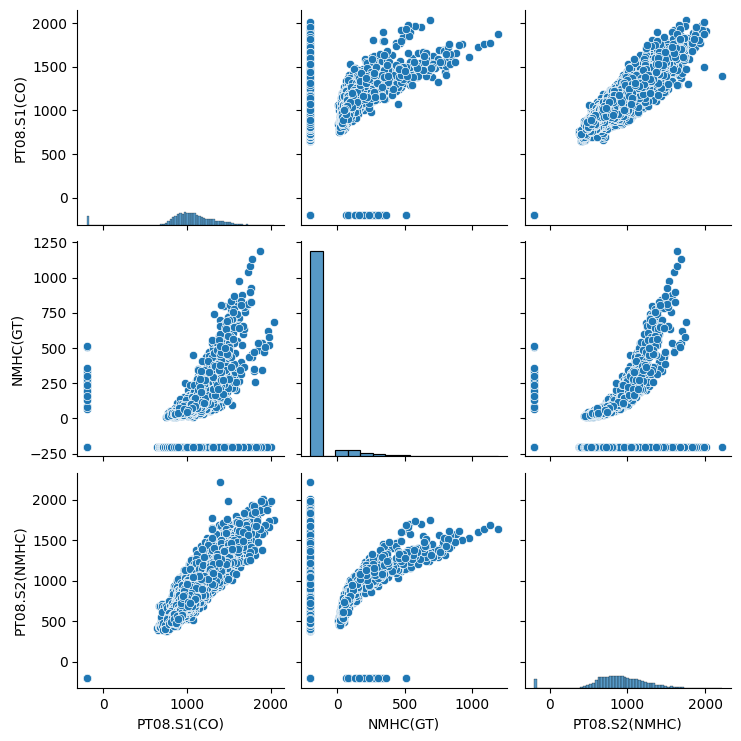

In [ ]:
sns.pairplot(data[['PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)']])
plt.show()

Correlation Matrix

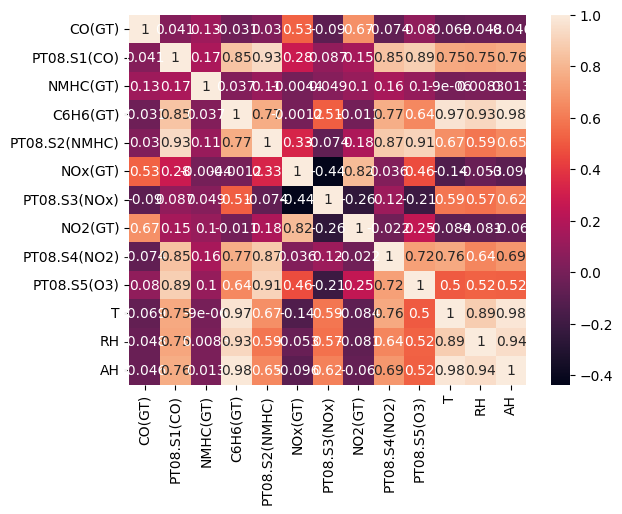

<Figure size 4000x3000 with 0 Axes>

In [ ]:
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True)
plt.figure(figsize=(40, 30))
plt.show()

Histogram Plots of different cols

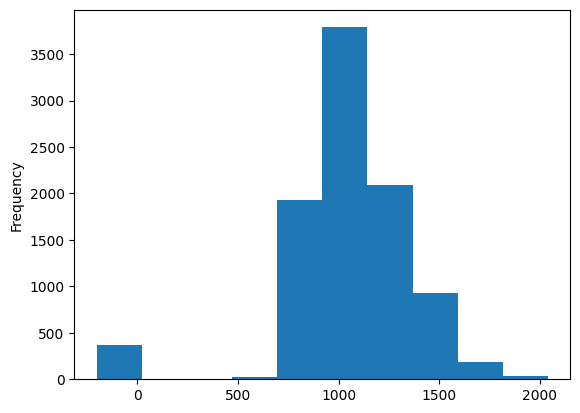

In [ ]:
data['PT08.S1(CO)'].plot(kind='hist')
plt.show()

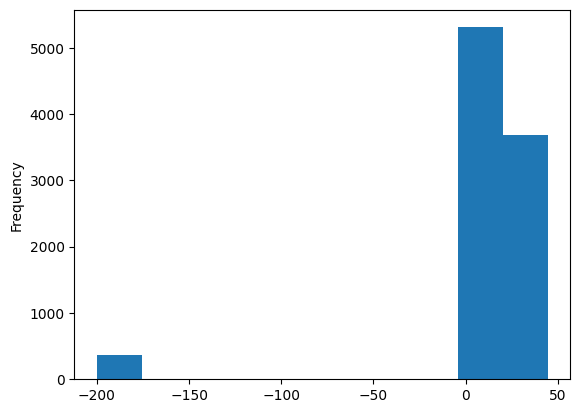

In [ ]:
data['T'].plot(kind='hist')
plt.show()

#Normalizing

In [ ]:
scaler = StandardScaler()
data_dropped = scaler.fit_transform(data_dropped)

In [ ]:
X_scaled = data_dropped[:, :-1]
y = data_dropped[:, -1]

In [ ]:
def to_tensor(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    return X_tensor, y_tensor

X, y = to_tensor(X_scaled, y)

In [ ]:
seql = 10

In [ ]:
X_unfolded = X.unfold(0, seql, 1)
X_unfolded = X_unfolded.unsqueeze(2)
X_seq = X_unfolded.transpose(1, 2)

y_seq = y[seql - 1:]
y_seq = torch.tensor(y_seq, dtype=torch.float32)

<ipython-input-85-e8ec6883a343>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_seq = torch.tensor(y_seq, dtype=torch.float32)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def create_dataset_and_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset, dataloader

train_dataset, train_dataloader = create_dataset_and_dataloader(X_train, y_train)
val_dataset, val_dataloader = create_dataset_and_dataloader(X_val, y_val, shuffle=False)
test_dataset, test_dataloader = create_dataset_and_dataloader(X_test, y_test, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, lstm_hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

input_size, hidden_size, lstm_hidden_size = 10, 10, 15
output_size = 1
num_layers = 3

model = RNNModel(input_size, hidden_size, lstm_hidden_size, num_layers, output_size)
model.to(device)

print(model)

RNNModel(
  (rnn): RNN(10, 10, num_layers=3, batch_first=True)
  (lstm): LSTM(10, 15, num_layers=3, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim

learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

In [ ]:
num_epochs = 10

train_losses = []
val_losses = []

train_r2_scores = []
val_r2_scores = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_predictions = []

    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X.squeeze(dim=1))
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Collecting predictions for the training set
        train_predictions.append(output.cpu().detach().numpy())

    average_train_loss = total_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    # Concatenate predictions and targets for R2 score calculation
    train_predictions = np.concatenate(train_predictions)
    train_targets = y_train.cpu().numpy()
    train_r2 = r2_score(train_targets, train_predictions)
    train_r2_scores.append(train_r2)

    model.eval()
    val_loss = 0
    val_predictions = []

    with torch.no_grad():
        for batch_val_X, batch_val_y in val_dataloader:
            batch_val_X, batch_val_y = batch_val_X.to(device), batch_val_y.to(device)
            val_op = model(batch_val_X.squeeze(dim=1))
            val_loss += criterion(val_op.squeeze(), batch_val_y).item()

            # Collecting predictions for the validation set
            val_predictions.append(val_op.cpu().detach().numpy())

    average_val_loss = val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)

    # Concatenate predictions and targets for R2 score calculation
    val_predictions = np.concatenate(val_predictions)
    val_targets = y_val.cpu().numpy()
    val_r2 = r2_score(val_targets, val_predictions)
    val_r2_scores.append(val_r2)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Train R2: {train_r2:.4f}, Val R2: {val_r2:.4f}')

Epoch 1/10, Train Loss: 0.5326, Val Loss: 0.1834, Train R2: -0.1906, Val R2: 0.8282
Epoch 2/10, Train Loss: 0.0403, Val Loss: 0.0187, Train R2: -0.8288, Val R2: 0.9825
Epoch 3/10, Train Loss: 0.0030, Val Loss: 0.1108, Train R2: -0.9816, Val R2: 0.8962
Epoch 4/10, Train Loss: 0.0143, Val Loss: 0.0019, Train R2: -0.9838, Val R2: 0.9983
Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0023, Train R2: -1.0232, Val R2: 0.9978
Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0024, Train R2: -0.9747, Val R2: 0.9978
Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0023, Train R2: -0.9820, Val R2: 0.9979
Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0024, Train R2: -0.9657, Val R2: 0.9977
Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0024, Train R2: -1.0152, Val R2: 0.9977
Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0025, Train R2: -0.9900, Val R2: 0.9977


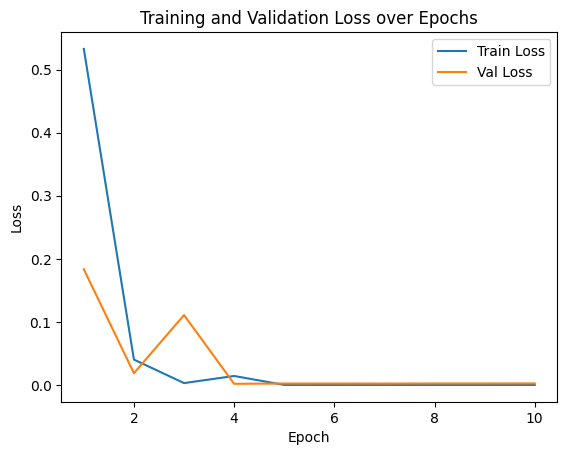

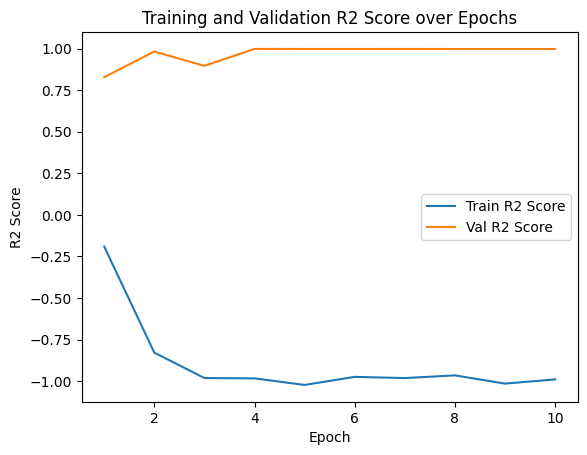

In [ ]:
# Plotting the training and validation loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plotting the training and validation R2 scores over epochs
plt.plot(range(1, num_epochs + 1), train_r2_scores, label='Train R2 Score')
plt.plot(range(1, num_epochs + 1), val_r2_scores, label='Val R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Training and Validation R2 Score over Epochs')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

model.eval()
test_loss = 0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_test_X, batch_test_y in test_dataloader:
        batch_test_X, batch_test_y = batch_test_X.to(device), batch_test_y.to(device)
        test_op = model(batch_test_X.squeeze(dim=1))
        test_loss += criterion(test_op, batch_test_y).item()

        # Collect predictions and targets for metrics calculation
        test_predictions.append(test_op.cpu().numpy())
        test_targets.append(batch_test_y.cpu().numpy())

average_test_loss = test_loss / len(test_dataloader)
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

test_mae = mean_absolute_error(test_targets, test_predictions)
test_rmse = math.sqrt(mean_squared_error(test_targets, test_predictions))

print(f"Test Loss: {average_test_loss:.4f}, Test MAE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}")


Test Loss: 1.8710, Test MAE: 0.0083, Test RMSE: 0.0106


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
from sklearn.metrics import r2_score

# Evaluate the model on the test dataset
model.eval()
predictions = []

with torch.no_grad():
    for batch_test_X, batch_test_y in test_dataloader:
        batch_test_X, batch_test_y = batch_test_X.to(device), batch_test_y.to(device)
        test_op = model(batch_test_X.squeeze(dim=1))
        predictions.append(test_op.cpu().numpy())

predictions = np.concatenate(predictions)
true_labels = y_test.numpy()

r2 = r2_score(true_labels, predictions)
print(f"R2 Score: {r2:.6f}")

R2 Score: 0.999884


In [ ]:
torch.save(model.state_dict(), 'rnn_model.pth')

#Optimized Model(L2 Regularization, Dropout)

In [ ]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_hidden_size, num_layers, output_size, dropout_prob=0.5, weight_decay=1e-5):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, lstm_hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(lstm_hidden_size, output_size)

        # Adding L2 regularization to the optimizer
        self.weight_decay = weight_decay

    def forward(self, x):
        out, _ = self.rnn(x)
        out, _ = self.lstm(out)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

input_size, hidden_size, lstm_hidden_size = 10, 10, 15
output_size = 1
num_layers = 3

model = RNNModel(input_size, hidden_size, lstm_hidden_size, num_layers, output_size)
model.to(device)

print(model)

import torch.optim as optim

learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=model.weight_decay)

RNNModel(
  (rnn): RNN(10, 10, num_layers=3, batch_first=True)
  (lstm): LSTM(10, 15, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)


In [ ]:
num_epochs = 10

train_losses = []
val_losses = []

train_r2_scores = []
val_r2_scores = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_predictions = []

    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X.squeeze(dim=1))
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Collecting predictions for the training set
        train_predictions.append(output.cpu().detach().numpy())

    average_train_loss = total_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    # Concatenate predictions and targets for R2 score calculation
    train_predictions = np.concatenate(train_predictions)
    train_targets = y_train.cpu().numpy()
    train_r2 = r2_score(train_targets, train_predictions)
    train_r2_scores.append(train_r2)

    model.eval()
    val_loss = 0
    val_predictions = []

    with torch.no_grad():
        for batch_val_X, batch_val_y in val_dataloader:
            batch_val_X, batch_val_y = batch_val_X.to(device), batch_val_y.to(device)
            val_op = model(batch_val_X.squeeze(dim=1))
            val_loss += criterion(val_op.squeeze(), batch_val_y).item()

            # Collecting predictions for the validation set
            val_predictions.append(val_op.cpu().detach().numpy())

    average_val_loss = val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)

    # Concatenate predictions and targets for R2 score calculation
    val_predictions = np.concatenate(val_predictions)
    val_targets = y_val.cpu().numpy()
    val_r2 = r2_score(val_targets, val_predictions)
    val_r2_scores.append(val_r2)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Train R2: {train_r2:.4f}, Val R2: {val_r2:.4f}')

Epoch 1/10, Train Loss: 0.6527, Val Loss: 0.2032, Train R2: -0.1404, Val R2: 0.8097
Epoch 2/10, Train Loss: 0.1052, Val Loss: 0.0586, Train R2: -0.6784, Val R2: 0.9451
Epoch 3/10, Train Loss: 0.0798, Val Loss: 0.0071, Train R2: -0.8755, Val R2: 0.9934
Epoch 4/10, Train Loss: 0.0601, Val Loss: 0.0147, Train R2: -0.9466, Val R2: 0.9862
Epoch 5/10, Train Loss: 0.0753, Val Loss: 0.0035, Train R2: -0.9159, Val R2: 0.9967
Epoch 6/10, Train Loss: 0.0660, Val Loss: 0.0052, Train R2: -0.9605, Val R2: 0.9952
Epoch 7/10, Train Loss: 0.0744, Val Loss: 0.0077, Train R2: -0.9344, Val R2: 0.9928
Epoch 8/10, Train Loss: 0.0677, Val Loss: 0.0082, Train R2: -0.9505, Val R2: 0.9923
Epoch 9/10, Train Loss: 0.0679, Val Loss: 0.0077, Train R2: -0.9418, Val R2: 0.9928
Epoch 10/10, Train Loss: 0.0697, Val Loss: 0.0040, Train R2: -0.9222, Val R2: 0.9962


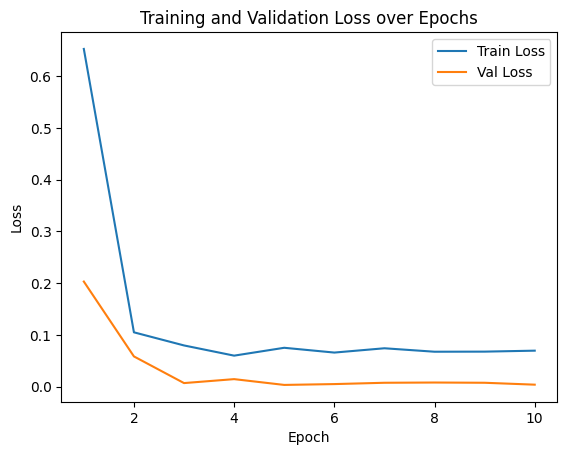

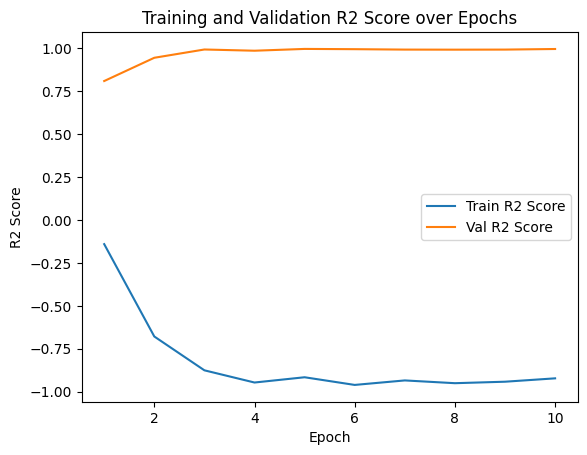

In [ ]:
# Plotting the training and validation loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plotting the training and validation R2 scores over epochs
plt.plot(range(1, num_epochs + 1), train_r2_scores, label='Train R2 Score')
plt.plot(range(1, num_epochs + 1), val_r2_scores, label='Val R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Training and Validation R2 Score over Epochs')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

model.eval()
test_loss = 0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_test_X, batch_test_y in test_dataloader:
        batch_test_X, batch_test_y = batch_test_X.to(device), batch_test_y.to(device)
        test_op = model(batch_test_X.squeeze(dim=1))
        test_loss += criterion(test_op, batch_test_y).item()

        # Collect predictions and targets for metrics calculation
        test_predictions.append(test_op.cpu().numpy())
        test_targets.append(batch_test_y.cpu().numpy())

average_test_loss = test_loss / len(test_dataloader)
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

test_mae = mean_absolute_error(test_targets, test_predictions)
test_rmse = math.sqrt(mean_squared_error(test_targets, test_predictions))

print(f"Test Loss: {average_test_loss:.4f}, Test MAE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}")


Test Loss: 1.7624, Test MAE: 0.0257, Test RMSE: 0.0602


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
from sklearn.metrics import r2_score

# Evaluate the model on the test dataset
model.eval()
predictions = []

with torch.no_grad():
    for batch_test_X, batch_test_y in test_dataloader:
        batch_test_X, batch_test_y = batch_test_X.to(device), batch_test_y.to(device)
        test_op = model(batch_test_X.squeeze(dim=1))
        predictions.append(test_op.cpu().numpy())

predictions = np.concatenate(predictions)
true_labels = y_test.numpy()

r2 = r2_score(true_labels, predictions)
print(f"R2 Score: {r2:.6f}")

R2 Score: 0.996259


In [ ]:
torch.save(model.state_dict(), 'optimized_rnn_model.pth')